## import modules

In [22]:
include("../src/EEGAnalysis.jl")
using DSP
using Statistics
using Printf
using Plots
gr(fmt="png", size=(512,384))  # 8:6

Plots.GRBackend()

# Compact Data

In [3]:
datadir = "../../Data"
resultdir = "../../Result"
patientName = "Chen Zhou"
expname = "180831-3-10"
fs = 2000
roi = (-2.0, 10.0)

@time container =  EEGAnalysis.Container.createCompactDataContainer(datadir, resultdir, patientName, expname, fs, roi);

  0.748699 seconds (2.42 k allocations: 430.539 MiB, 3.02% gc time)


## wavelet transform

Here, we perform the wavelet transform on the entire raw data of one channel

In [4]:
Chidx = 99
#DSP 3.75 sec; FastConv 7.24 sec
#python3 5.0 sec
ch_raw = container.channels[Chidx,:]
frange = 10 .^ range(log10(1), stop=log10(200), length=40)
@time ch_dwt = EEGAnalysis.Decomposition.dwt(ch_raw, 2000.0, frange, reflection=false);
frange

  5.296183 seconds (3.96 M allocations: 2.076 GiB, 10.71% gc time)


40-element Array{Float64,1}:
   1.0               
   1.1455149701087122
   1.3122045467431636
   1.503149952139011 
   1.7218807724934313
   1.9724402016335787
   2.2594597786155113
   2.5882450007625843
   2.9648733946825754
   3.3963068580859264
   3.890520349020313 
   4.45664930131534  
   5.105158491181254 
   ⋮                 
  44.87676424101214  
  51.40700524811874  
  58.88749408017715  
  67.45650602103109  
  77.27243747831959  
  88.51673390820459  
 101.3972437969778   
 116.15206069720077  
 133.05392433761932  
 152.41526216045477  
 174.59396447784496  
 200.00000000000003  

## epoching

In [23]:
@time ch_epoch = EEGAnalysis.Container.createEpochByMarker(ch_dwt, container.markers["grating"], (-2.0, 10.0), 2000.0);
size(ch_epoch)

  1.315582 seconds (107.50 k allocations: 1.128 GiB, 15.80% gc time)


(40, 20, 24000)

## total power

In [12]:
totalpwr = Statistics.mean(abs.(ch_epoch),dims=2) |> (x) -> dropdims(x, dims=2) .|> log10;
totalpwr_zscore = (totalpwr .- Statistics.mean(totalpwr, dims=2)) ./ Statistics.std(totalpwr, dims=2)
size(totalpwr_zscore)

(40, 24000)

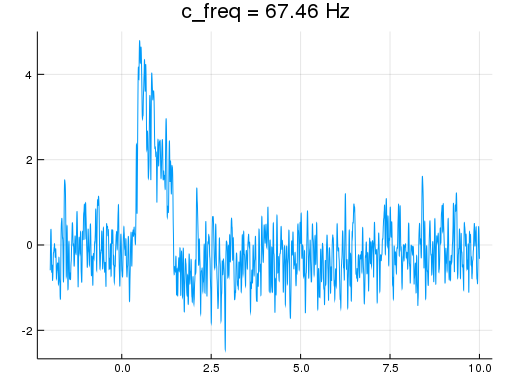

In [71]:
tspec = range(-2, stop=10, length=24000)
a = plot(tspec, totalpwr_zscore[32,:], title=@Printf.sprintf("c_freq = %.2f Hz", frange[32]), legend=false)

## guassian filter of total power

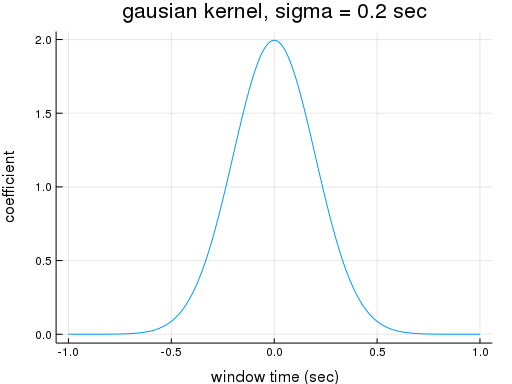

In [68]:
function gaussian_kernel(fs::T, sigma::T) where {T}
    ktime = range(-1, stop=1, length=Int(2*fs))
    kernel = 1/(sqrt(2*pi)*sigma) * exp.(-ktime.^2 / (2*sigma^2))
    return kernel |> Array{T}
end

# preview kernel function
k = gaussian_kernel(2000.0, 0.2)
k_t = range(-1,stop=1,length=4000)
plot(k_t, k, xlabel="window time (sec)", ylabel="coefficient")
plot!(legend=false, title="gausian kernel, sigma = 0.2 sec")

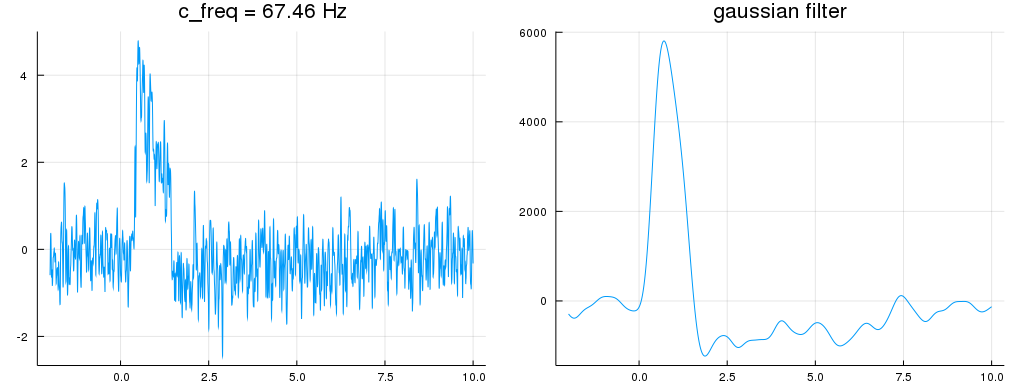

In [73]:
totalpwr_filter = DSP.conv(totalpwr_zscore[32,:], gaussian_kernel(2000.0, 0.2));
b = plot(tspec, totalpwr_filter[2000:end-2000], legend=false, title="gaussian filter")
plot(a,b, size=(1024, 386))

## Butterworth Filter

  0.014363 seconds (114 allocations: 6.785 MiB)


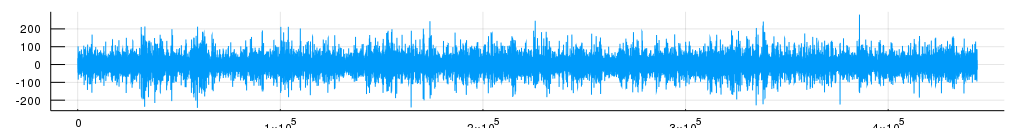

In [81]:
x = container.channels[99,:]
# responsetype = DSP.Bandpass(30, 80; fs=2000)
responsetype = DSP.Highpass(5; fs=2000.0)
designmethod = DSP.Butterworth(4)
@time xf = DSP.filtfilt(DSP.digitalfilter(responsetype, designmethod), x);
plot(xf, size=(1024, 128), legend=false)

## TODO: open a issue

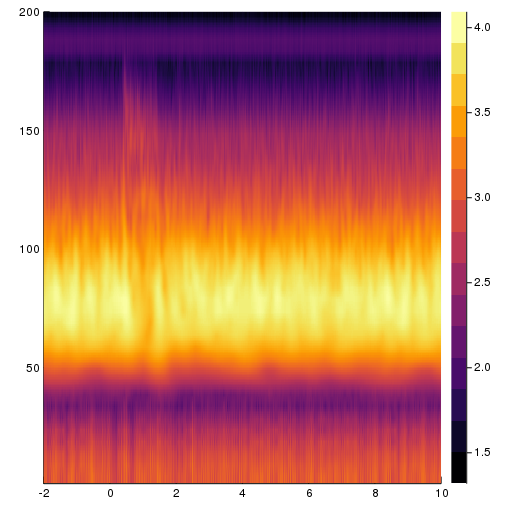

In [105]:
contour(range(-2, stop=10, length=24000), frange, kkkk, fill=true)